In [1]:
from datasets import MultiTaskDataset
from alg.coreset import Coreset, CoresetConfig
from alg.vcl_net import Initialization, MultiHeadVCLSplitMNIST, MultiHeadVCLSplitNotMNIST
import seaborn as sns
import pandas as pd
import torch
from torch import nn
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy as dc

In [2]:
from typing import Union, Literal

def train_MLE(model, _train_x, _train_y, task_i, n_epochs, batch_size, verbose):
    def get_accuracy(model, x, y, task_i, batch_size):
        pred_y = []
        with torch.no_grad():
            for batch in range(int(np.ceil(x.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                logits = nn.Softmax(-1)(model.predict_MLE(x[batch_idx0:batch_idx1], task_i))
                pred_y.append(logits.argmax(-1))
            pred_y = torch.cat(pred_y)
            acc = (pred_y == y).cpu().numpy().mean()
        return acc

    current_opt = torch.optim.Adam(model.parameters(), lr=0.01)
    num_datapoints = _train_x.shape[0]
    train_x, train_y, val_x, val_y = _train_x[:int(num_datapoints*0.8)].clone(), _train_y[:int(num_datapoints*0.8)].clone(), _train_x[int(num_datapoints*0.8):].clone(), _train_y[int(num_datapoints*0.8):].clone()
    best_val_loss = None
    best_locs = None
    for epoch in (tqdm if verbose else iter)(range(n_epochs)):
        model.train()
        ELBO_batch = []
        for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            current_opt.zero_grad()
            loss = model.MLE_loss(x=train_x[batch_idx0: batch_idx1], 
                                                y=train_y[batch_idx0: batch_idx1], 
                                                task_i_mask=task_i)
            nn.utils.clip_grad_value_(model.parameters(), 5)
            loss.backward()
            current_opt.step()
        model.eval()
        with torch.no_grad():
            val_loss = model.MLE_loss(x=val_x, y=val_y, task_i_mask=task_i)
            if best_val_loss is None or val_loss < best_val_loss:
                best_val_loss = val_loss
                # print(val_loss)
                locs, _ = model.get_params()
                best_locs = locs
        
    locs, vars = model.get_params()
    with torch.no_grad():
        model.set_params(best_locs, vars)

    if verbose:
        print(f"Validation accuracy on MLE model: {get_accuracy(model, val_x, val_y, task_i, 1000000)}")
    model.train()
    return model

def run(
        model_name: str,
        dataset: Literal['split MNIST', 'split notMNIST'], 
        first_init: Initialization = Initialization.RANDOM, 
        subsequent_head_init: Initialization = Initialization.RANDOM, 
        shared_net_init: Union[Initialization, None] = None, 
        n_epochs=120, 
        batch_size=256, 
        coreset_config=None,
        gvcl_elbo=False,
        verbose=False
    ):
    if dataset == 'split MNIST':
        model_cls = MultiHeadVCLSplitMNIST
    elif dataset == 'split notMNIST':
        model_cls = MultiHeadVCLSplitNotMNIST
    else:
        raise Exception(f"Invalid dataset: {dataset}")
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    test_x_all = []
    test_y_all = []
    test_task_i_all = []

    coreset = Coreset(coreset_config)
    dataset = MultiTaskDataset(dataset, device)
    accuracies = []

    # <GVCL parameters>
    annealing_beta_prop = 0.5
    annealing_beta_pred = 0.05
    _lambda = 10
    # </GVCL parameters>

    previous_model, pred_model = None, None
    for task_i in range(5):
        train_x, train_y, test_x, test_y = dataset.get_task_dataset(task_i)
        test_x_all.append(test_x)
        test_y_all.append(test_y)
        test_task_i_all.append(torch.ones((test_x.shape[0]), dtype=int) * task_i)

        train_x, train_y = coreset.update(train_x, train_y, task_i)
        coreset.post_process(task_i, pred_model.shared if pred_model is not None else None)

        # define current model
        if task_i == 0:
            if first_init is Initialization.CUSTOM:
                pretrained_model = train_MLE(model_cls(num_heads=1, initialization=Initialization.RANDOM).to(device), train_x, train_y, 0, 100, 500, verbose)
                current_model = model_cls(num_heads=1, initialization=Initialization.CUSTOM, custom_init=pretrained_model).to(device)
            else:
                assert isinstance(first_init, Initialization)
                current_model = model_cls(num_heads=1, initialization=first_init).to(device)
            current_model.set_prior(model_cls(num_heads=1, initialization=Initialization.DEFAULT).to(device))
        else:
            current_model = model_cls.new_from_prior(previous_model)
            current_model.add_head(initialization=subsequent_head_init)
            if shared_net_init is not None:
                assert isinstance(shared_net_init, Initialization)
                current_model.init_shared_weights(shared_net_init)

        assert len(current_model.heads) == task_i + 1
        current_opt = torch.optim.Adam(current_model.parameters(), lr=0.001)

        ELBO = []
        for epoch in (tqdm if verbose else iter)(range(n_epochs)):
            ELBO_batch = []
            for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                current_opt.zero_grad()
                if not gvcl_elbo:
                    elbo = current_model.calculate_ELBO(
                                                        x=train_x[batch_idx0: batch_idx1], 
                                                        y=train_y[batch_idx0: batch_idx1], 
                                                        n_particles=1,
                                                        task_i_mask=task_i,
                                                        dataset_size=train_x.shape[0])
                else:
                    elbo = current_model.calculate_GVCL_ELBO(
                                    x=train_x[batch_idx0: batch_idx1], 
                                    y=train_y[batch_idx0: batch_idx1], 
                                    n_particles=1,
                                    task_i_mask=task_i,
                                    dataset_size=train_x.shape[0],
                                    _lambda=_lambda,
                                    beta=annealing_beta_pred)
                elbo.backward()
                nn.utils.clip_grad_value_(current_model.parameters(), 5)
                current_opt.step()
                ELBO_batch.append(elbo.item())
            ELBO.append(np.mean(ELBO_batch))
        if verbose:
            plt.plot(ELBO)
            plt.yscale("log")
            plt.show()

        test_x_tensor = torch.cat(test_x_all)
        test_y_tensor = torch.cat(test_y_all)
        test_task_i_mask_tensor = torch.cat(test_task_i_all)
        assert set([k.item() for k in test_task_i_mask_tensor.unique()]) == set([i for i in range(task_i + 1)]), f"{set([k.item() for k in test_task_i_mask_tensor.unique()])} != {set([i for i in range(task_i + 1)])} Invalid, {test_task_i_mask_tensor.unique()}"
        pred_y = []
        with torch.no_grad():
            for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                pred_logit_samples = nn.Softmax(-1)(torch.stack(current_model.predict(test_x_tensor[batch_idx0:batch_idx1], test_task_i_mask_tensor[batch_idx0:batch_idx1], 100), 0)).mean(0)
                pred_y.append(pred_logit_samples.argmax(-1))
            pred_y = torch.cat(pred_y)
            acc = (pred_y == test_y_tensor).cpu().numpy().mean()
        if verbose:
            print("Accuracy by the propagation model is %.4f"%acc)


        # calculate prediction model
        pred_model = model_cls.new_from_prior(current_model)
        pred_opt = torch.optim.Adam(pred_model.parameters(), lr=0.001)

        ELBO = []
        for epoch in (tqdm if verbose else iter)(range(n_epochs)):
            ELBO_batch = []
            for batch in range(int(np.ceil(coreset.x[coreset.mult_mask].shape[0] / batch_size))):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                pred_opt.zero_grad()
                if not gvcl_elbo:
                    elbo = current_model.calculate_ELBO(
                                                    x=coreset.x[coreset.mult_mask][batch_idx0: batch_idx1], 
                                                    y=coreset.y[coreset.mult_mask][batch_idx0: batch_idx1], 
                                                    task_i_mask=coreset.task_mask[coreset.mult_mask][batch_idx0: batch_idx1],
                                                    n_particles=1,
                                                    dataset_size=coreset.x[coreset.mult_mask].shape[0])
                else:
                    elbo = current_model.calculate_GVCL_ELBO(
                                                    x=coreset.x[coreset.mult_mask][batch_idx0: batch_idx1], 
                                                    y=coreset.y[coreset.mult_mask][batch_idx0: batch_idx1], 
                                                    task_i_mask=coreset.task_mask[coreset.mult_mask][batch_idx0: batch_idx1],
                                                    n_particles=1,
                                                    dataset_size=coreset.x[coreset.mult_mask].shape[0],
                                                    _lambda=_lambda,
                                                    beta=annealing_beta_pred)
                elbo.backward()
                nn.utils.clip_grad_value_(pred_model.parameters(), 5)
                pred_opt.step()
                ELBO_batch.append(elbo.item())
            ELBO.append(np.mean(ELBO_batch))
        if verbose:
            plt.plot(ELBO)
            plt.show()

        total_avg_acc = 0
        for idx in range(len(test_x_all)):
            test_x_tensor = test_x_all[idx]     
            test_y_tensor = test_y_all[idx]
            test_task_i_mask_tensor = test_task_i_all[idx]
            pred_y = []
            with torch.no_grad():
                for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
                    batch_idx0 = batch * batch_size
                    batch_idx1 = batch * batch_size + batch_size
                    pred_logit_samples = nn.Softmax(-1)(torch.stack(pred_model.predict(test_x_tensor[batch_idx0:batch_idx1], test_task_i_mask_tensor[batch_idx0:batch_idx1], 100), 0)).mean(0)
                    pred_y.append(pred_logit_samples.argmax(-1))
                pred_y = torch.cat(pred_y)
                acc = (pred_y == test_y_tensor).cpu().numpy().mean()
                accuracies.append((acc, task_i, idx, model_name))
                # We weight by how many datapoints are in the available test sets (may not be balanced)
                total_avg_acc += acc * test_x_tensor.shape[0] / float(sum([t.shape[0] for t in test_x_all]))
        accuracies.append((total_avg_acc, task_i, "All", model_name))
        if verbose:
            print("Task {:d}, Accuracy: {:.4f}".format(task_i, acc))
        previous_model = current_model
    return accuracies


In [3]:
def get_columns():
    return ["Accuracy", "Task Index", "Target Task", "Model"]

def new_results_df():
    return pd.DataFrame(columns=get_columns())

def update_results_df(results_df, results_list):
    df_temp = pd.DataFrame(results_list, columns=get_columns())
    return pd.concat([results_df, df_temp], ignore_index=True, axis=0)

def ensure_file_does_not_exist(file_name):
    from os import path
    assert not path.exists(file_name)

def to_dict(**config):
    return config

In [4]:
def run_experiment(configs, results_df, num_runs=10):
    for config in tqdm(configs, desc='Running experiment', position=0):
        for i in tqdm(range(num_runs), desc=config['model_name'], position=1, leave=True):
            results = run(**config)
            results_df = update_results_df(results_df, results)
    return results_df

# Original and GVCL

Note: includes random initialisation from "Improving Variational Continual Learning"

### Split MNIST

In [12]:
results_df = new_results_df()

In [13]:
base_config = {
    'dataset': 'split MNIST',
    'first_init': Initialization.RANDOM,
    'subsequent_head_init': Initialization.RANDOM,
    'shared_net_init': None, 
    'batch_size': 100000, # (whole dataset)
}

configs = [{'model_name': model_name, 'gvcl_elbo': gvcl, **dc(base_config)} for model_name, gvcl in [('VCL', False), ('GVCL', True)]]

results_name = 'results/splitMNISTVCLvsGVCL.pkl'
ensure_file_does_not_exist(results_name)

results_df = run_experiment(configs, results_df)
results_df = results_df.to_pickle(results_name)

Running experiment:   0%|          | 0/2 [00:00<?, ?it/s]

VCL:   0%|          | 0/10 [00:00<?, ?it/s]

GVCL:   0%|          | 0/10 [00:00<?, ?it/s]

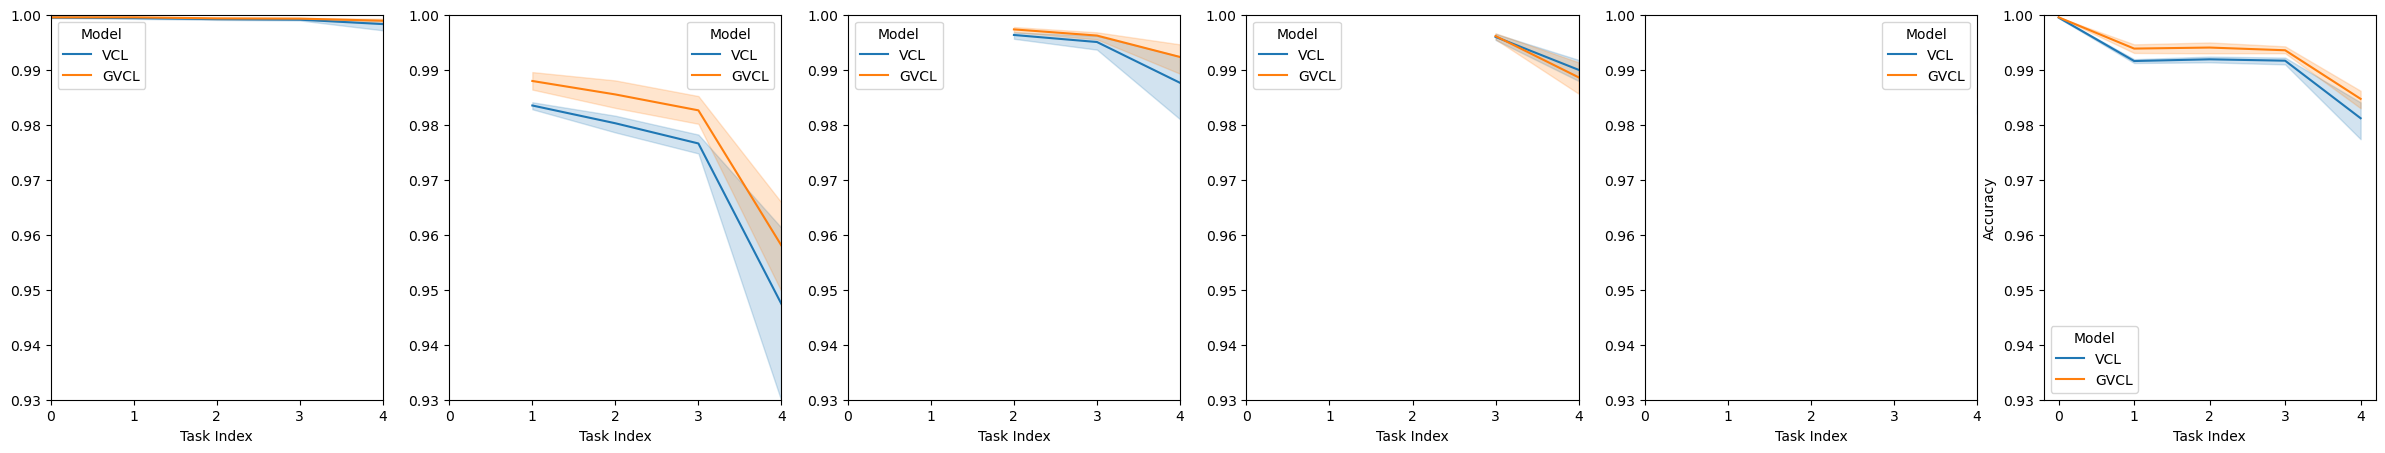

In [14]:
results_name = 'results/splitMNISTVCLvsGVCL.pkl'

results_df = pd.read_pickle(results_name)

fig, axs = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
for i in range(5):
    p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == i], ax=axs[i])
    p.set(xlim=(0, 4))
    p.set(ylim=(0.93, 1))
    p.set_ylabel(None)
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == 'All'], ax=axs[-1])
p.set(ylim=(0.93, 1));


### Split notMNIST

In [15]:
results_df = new_results_df()

In [16]:
base_config = {
    'dataset': 'split notMNIST',
    'first_init': Initialization.RANDOM,
    'subsequent_head_init': Initialization.RANDOM,
    'shared_net_init': None, 
    'batch_size': 100000, # (whole dataset)
}

configs = [{'model_name': model_name, 'gvcl_elbo': gvcl, **dc(base_config)} for model_name, gvcl in [('VCL', False), ('GVCL', True)]]

results_name = 'results/splitNotMNISTVCLvsGVCL.pkl'
ensure_file_does_not_exist(results_name)

results_df = run_experiment(configs, results_df)
results_df = results_df.to_pickle(results_name)

Running experiment:   0%|          | 0/2 [00:00<?, ?it/s]

VCL:   0%|          | 0/10 [00:00<?, ?it/s]

GVCL:   0%|          | 0/10 [00:00<?, ?it/s]

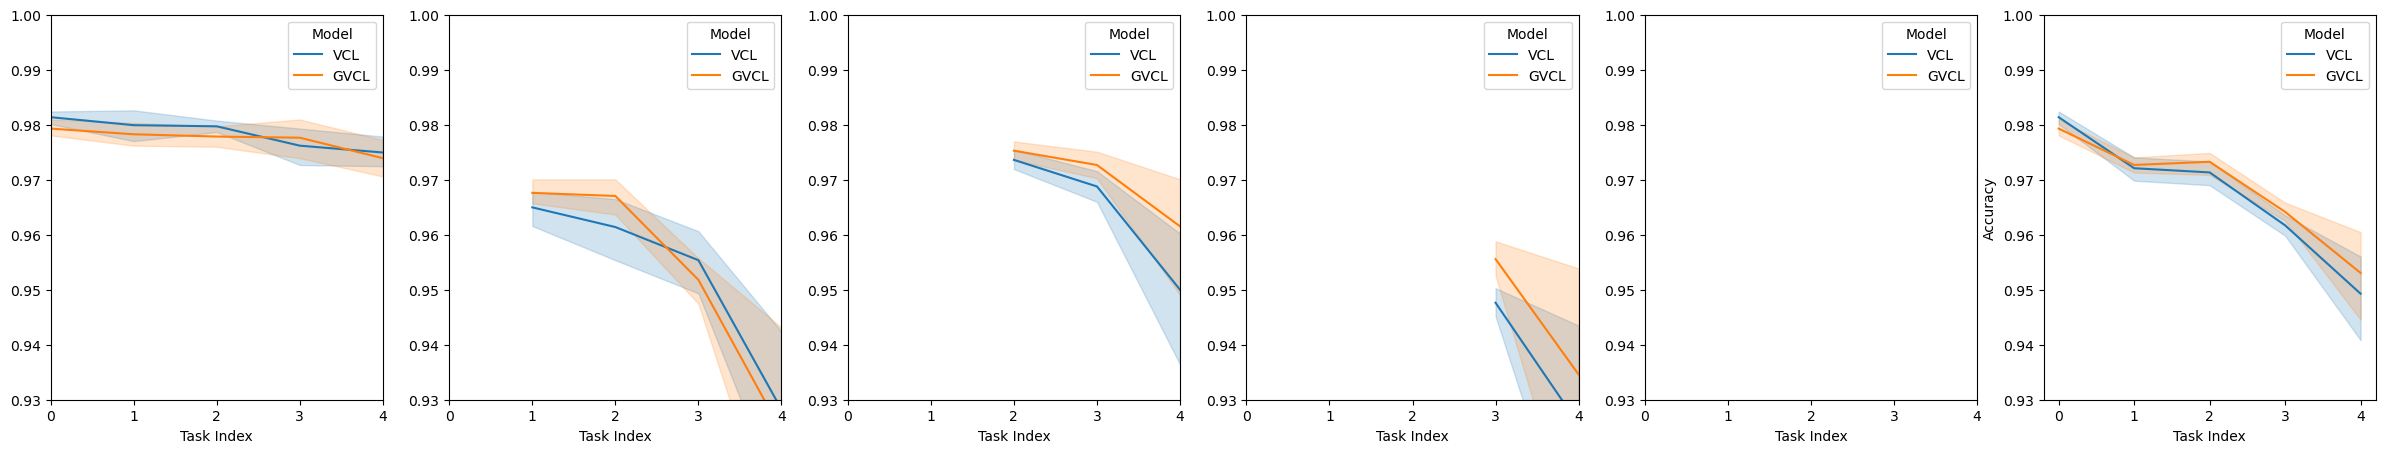

In [17]:
results_name = 'results/splitNotMNISTVCLvsGVCL.pkl'

results_df = pd.read_pickle(results_name)

fig, axs = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
for i in range(5):
    p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == i], ax=axs[i])
    p.set(xlim=(0, 4))
    p.set(ylim=(0.93, 1))
    p.set_ylabel(None)
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == 'All'], ax=axs[-1])
p.set(ylim=(0.93, 1));


# Coreset visualisation

In [6]:
device = "cpu"
dataset = MultiTaskDataset('split MNIST', device)
coreset_size = 4
task_i = 0

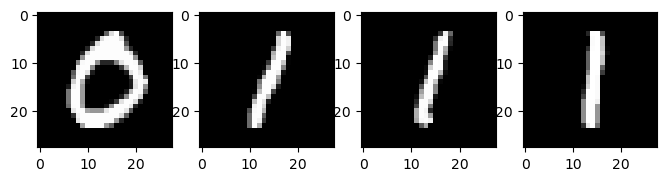

In [7]:
coreset_config= CoresetConfig(method='random', task_coreset_size=coreset_size, device=device)
coreset = Coreset(coreset_config)

train_x, train_y, test_x, test_y = dataset.get_task_dataset(task_i)
train_x, train_y = coreset.update(train_x, train_y, task_i)
f, axs = plt.subplots(1, coreset_size)
f.set_size_inches(2 * coreset_size, 2)
for i, ax in enumerate(axs):
    ax.imshow(coreset.x[i].reshape(28, 28), cmap="gray")

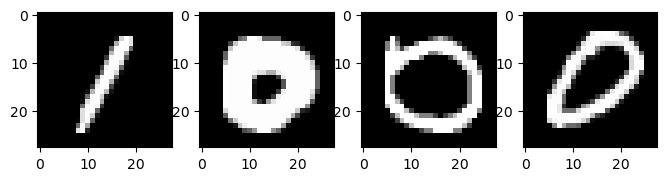

In [8]:
coreset_config= CoresetConfig(method='k-center', task_coreset_size=coreset_size, device=device)
coreset = Coreset(coreset_config)
train_x, train_y, test_x, test_y = dataset.get_task_dataset(task_i)
train_x, train_y = coreset.update(train_x, train_y, task_i)

f, axs = plt.subplots(1, coreset_size)
f.set_size_inches(2 * coreset_size, 2)
for i, ax in enumerate(axs):
    ax.imshow(coreset.x[i].reshape(28, 28), cmap="gray")

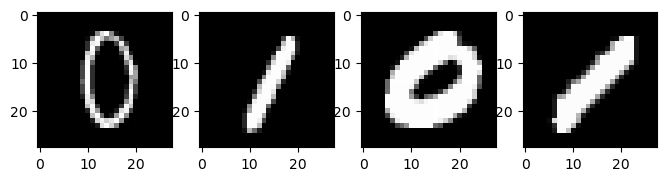

In [18]:
original_params = to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=1, emb_dim=8, hidden_dim_dec=256, num_hidden_dec=1)
coreset_config= CoresetConfig(method='vae-k-center', task_coreset_size=coreset_size, device=device, vae_params=to_dict(in_dim=784, hidden_dim_enc=512, num_hidden_enc=1, emb_dim=4, hidden_dim_dec=512, num_hidden_dec=1))
coreset = Coreset(coreset_config)
train_x, train_y, test_x, test_y = dataset.get_task_dataset(task_i)
train_x, train_y = coreset.update(train_x, train_y, task_i)

f, axs = plt.subplots(1, coreset_size)
f.set_size_inches(2 * coreset_size, 2)
for i, ax in enumerate(axs):
    ax.imshow(coreset.x[i].reshape(28, 28), cmap="gray")

# Coreset tests

### Split MNIST

#### Normal coreset size (40)

In [21]:
results_df = new_results_df()

In [23]:
base_config = {
    'dataset': 'split MNIST',
    'first_init': Initialization.RANDOM,
    'subsequent_head_init': Initialization.RANDOM,
    'shared_net_init': None, 
    'batch_size': 100000, # (whole dataset)
}

var = [('R', 'random'), ('K', 'k-center'), ('VAE+K', 'vae-k-center')]
configs = [{'model_name': model_name, 'coreset_config': CoresetConfig(method=coreset_method), **dc(base_config)} for model_name, coreset_method in var]

results_name = 'results/splitMNISTCoresetTest1.pkl'
ensure_file_does_not_exist(results_name)

results_df = run_experiment(configs, results_df)
results_df = results_df.to_pickle(results_name)

Running experiment:   0%|          | 0/3 [00:00<?, ?it/s]

R:   0%|          | 0/10 [00:00<?, ?it/s]

K:   0%|          | 0/10 [00:00<?, ?it/s]

VAE+K:   0%|          | 0/10 [00:00<?, ?it/s]

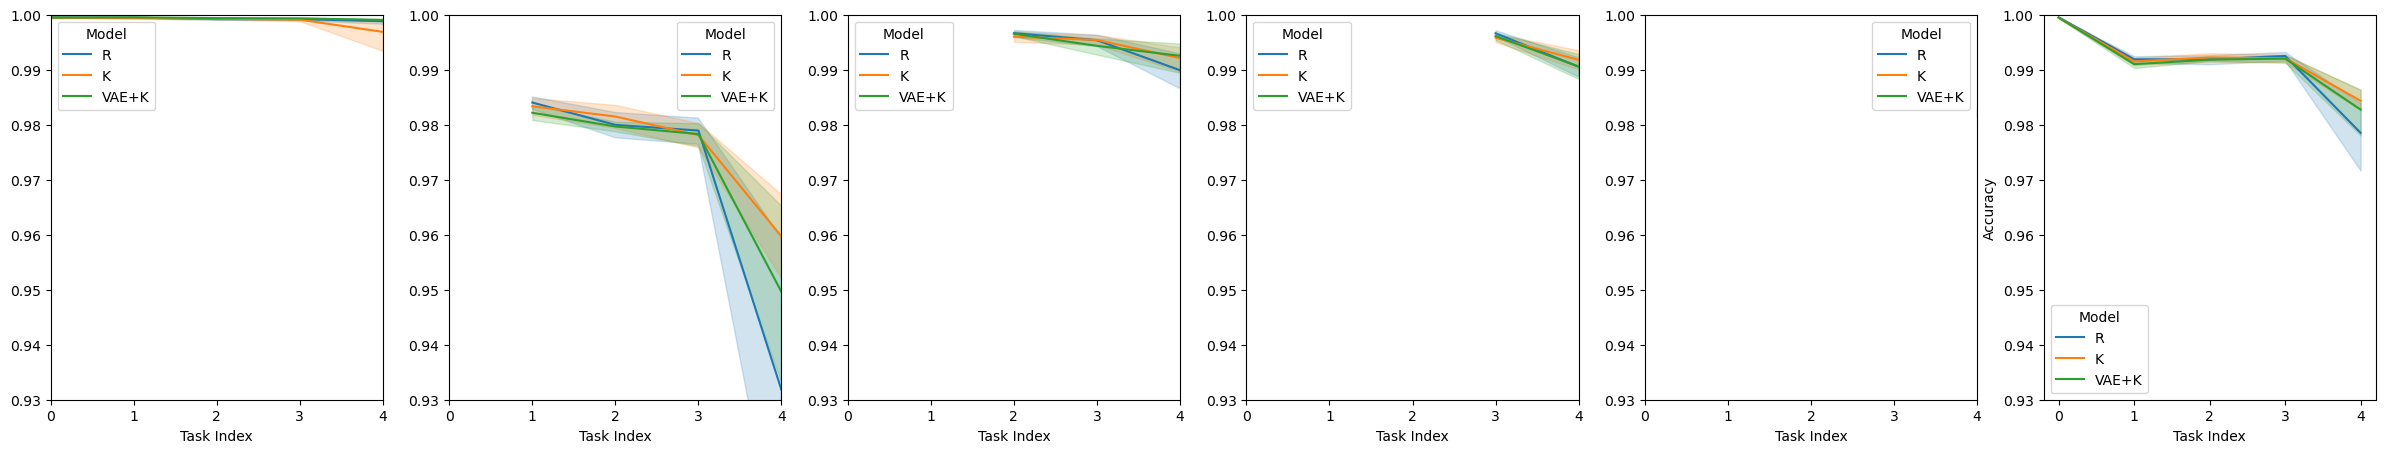

In [24]:
results_name = 'results/splitMNISTCoresetTest1.pkl'

results_df = pd.read_pickle(results_name)

fig, axs = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
for i in range(5):
    p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == i], ax=axs[i])
    p.set(xlim=(0, 4))
    p.set(ylim=(0.93, 1))
    p.set_ylabel(None)
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == 'All'], ax=axs[-1])
p.set(ylim=(0.93, 1));


### Split notMNIST

#### Different VAE configs (coreset_size = 10)

In [5]:
results_df = new_results_df()

In [8]:
base_config = {
    'dataset': 'split notMNIST',
    'first_init': Initialization.RANDOM,
    'subsequent_head_init': Initialization.RANDOM,
    'shared_net_init': None, 
    'batch_size': 100000, # (whole dataset)
}

var = [
    ('1', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=1, emb_dim=8, hidden_dim_dec=256, num_hidden_dec=1)),
    ('2', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=1, emb_dim=4, hidden_dim_dec=256, num_hidden_dec=1)),
    ('3', to_dict(in_dim=784, hidden_dim_enc=512, num_hidden_enc=1, emb_dim=8, hidden_dim_dec=512, num_hidden_dec=1)),
    ('4', to_dict(in_dim=784, hidden_dim_enc=512, num_hidden_enc=1, emb_dim=4, hidden_dim_dec=512, num_hidden_dec=1)),
    ('5', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=2, emb_dim=8, hidden_dim_dec=256, num_hidden_dec=2)),
    ('6', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=2, emb_dim=4, hidden_dim_dec=256, num_hidden_dec=2)),
    ('7', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=1, emb_dim=2, hidden_dim_dec=256, num_hidden_dec=1)),
    ('8', to_dict(in_dim=784, hidden_dim_enc=512, num_hidden_enc=1, emb_dim=2, hidden_dim_dec=512, num_hidden_dec=1)),
    ('9', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=2, emb_dim=2, hidden_dim_dec=256, num_hidden_dec=2)),
    ]
configs = [{'model_name': model_name, 'coreset_config': CoresetConfig(method='vae-k-center', vae_params=vae_params, task_coreset_size=10), **dc(base_config)} for model_name, vae_params in var]

results_name = 'results/splitNotMNISTCoresetTestDifferentSizes.pkl'
ensure_file_does_not_exist(results_name)

results_df = run_experiment(configs, results_df, num_runs=5)
results_df = results_df.to_pickle(results_name)

Running experiment:   0%|          | 0/3 [00:00<?, ?it/s]

7:   0%|          | 0/5 [00:00<?, ?it/s]

8:   0%|          | 0/5 [00:00<?, ?it/s]

9:   0%|          | 0/5 [00:00<?, ?it/s]

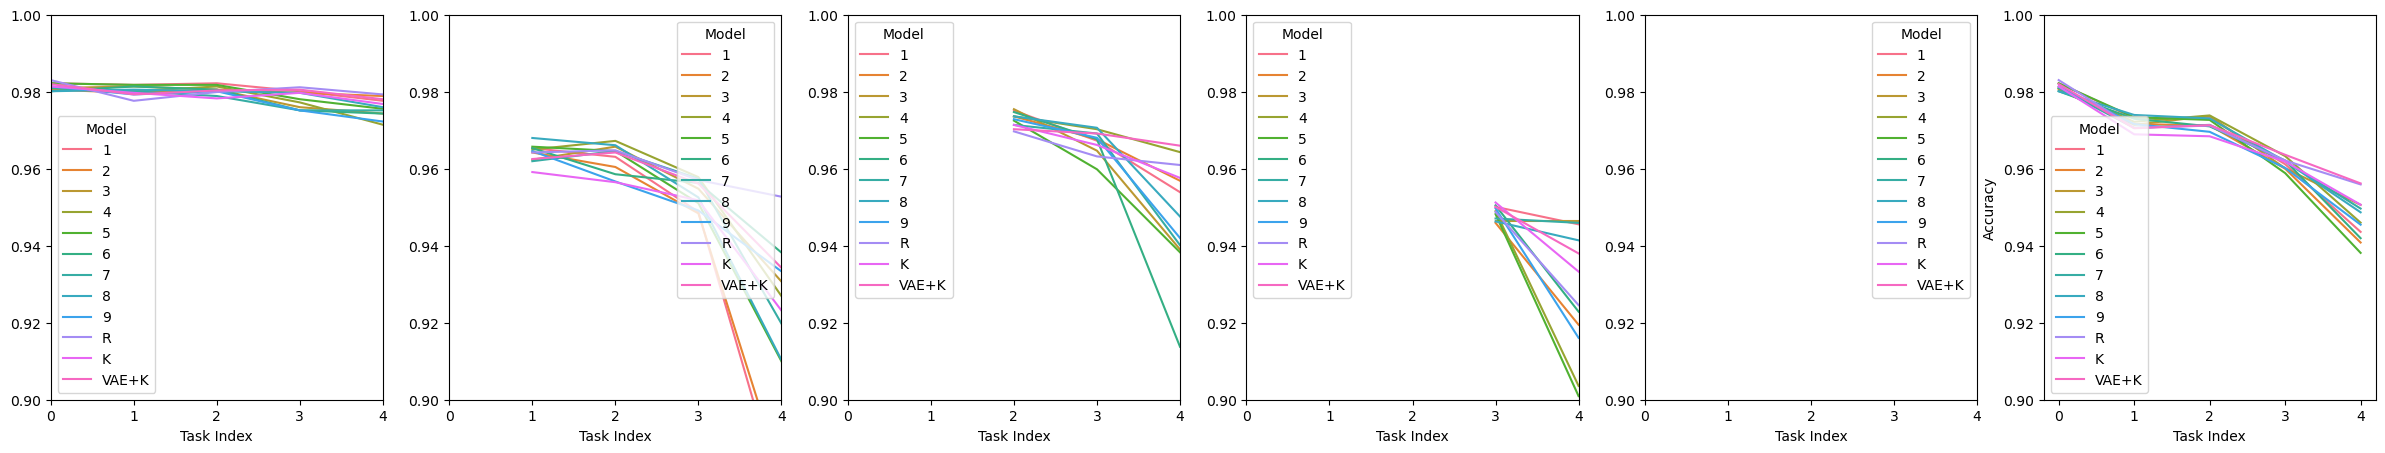

In [17]:
results_name = 'results/splitNotMNISTCoresetTestDifferentSizes.pkl'

results_df = pd.read_pickle(results_name)
results_df2 = pd.read_pickle('results/splitNotMNISTCoresetTest2.pkl')

res =  pd.concat([results_df, results_df2], ignore_index=True, axis=0)
fig, axs = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
for i in range(5):
    p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=res[res['Target Task'] == i], ax=axs[i], errorbar=None)
    p.set(xlim=(0, 4))
    p.set(ylim=(0.9, 1))
    p.set_ylabel(None)
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=res[res['Target Task'] == 'All'], ax=axs[-1], errorbar=None)
p.set(ylim=(0.9, 1));


#### Different VAE configs (coreset_size = 4)

In [18]:
results_df = new_results_df()

In [19]:
base_config = {
    'dataset': 'split notMNIST',
    'first_init': Initialization.RANDOM,
    'subsequent_head_init': Initialization.RANDOM,
    'shared_net_init': None, 
    'batch_size': 100000, # (whole dataset)
}

var = [
    ('1', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=1, emb_dim=8, hidden_dim_dec=256, num_hidden_dec=1)),
    ('2', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=1, emb_dim=4, hidden_dim_dec=256, num_hidden_dec=1)),
    ('3', to_dict(in_dim=784, hidden_dim_enc=512, num_hidden_enc=1, emb_dim=8, hidden_dim_dec=512, num_hidden_dec=1)),
    ('4', to_dict(in_dim=784, hidden_dim_enc=512, num_hidden_enc=1, emb_dim=4, hidden_dim_dec=512, num_hidden_dec=1)),
    ('5', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=2, emb_dim=8, hidden_dim_dec=256, num_hidden_dec=2)),
    ('6', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=2, emb_dim=4, hidden_dim_dec=256, num_hidden_dec=2)),
    ('7', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=1, emb_dim=2, hidden_dim_dec=256, num_hidden_dec=1)),
    ('8', to_dict(in_dim=784, hidden_dim_enc=512, num_hidden_enc=1, emb_dim=2, hidden_dim_dec=512, num_hidden_dec=1)),
    ('9', to_dict(in_dim=784, hidden_dim_enc=256, num_hidden_enc=2, emb_dim=2, hidden_dim_dec=256, num_hidden_dec=2)),
    ]
configs = [{'model_name': model_name, 'coreset_config': CoresetConfig(method='vae-k-center', vae_params=vae_params, task_coreset_size=4), **dc(base_config)} for model_name, vae_params in var]

results_name = 'results/splitNotMNISTCoresetTestDifferentSizes2.pkl'
ensure_file_does_not_exist(results_name)

results_df = run_experiment(configs, results_df, num_runs=5)
results_df = results_df.to_pickle(results_name)

Running experiment:   0%|          | 0/9 [00:00<?, ?it/s]

1:   0%|          | 0/5 [00:00<?, ?it/s]

2:   0%|          | 0/5 [00:00<?, ?it/s]

3:   0%|          | 0/5 [00:00<?, ?it/s]

4:   0%|          | 0/5 [00:00<?, ?it/s]

5:   0%|          | 0/5 [00:00<?, ?it/s]

6:   0%|          | 0/5 [00:00<?, ?it/s]

7:   0%|          | 0/5 [00:00<?, ?it/s]

8:   0%|          | 0/5 [00:00<?, ?it/s]

9:   0%|          | 0/5 [00:00<?, ?it/s]

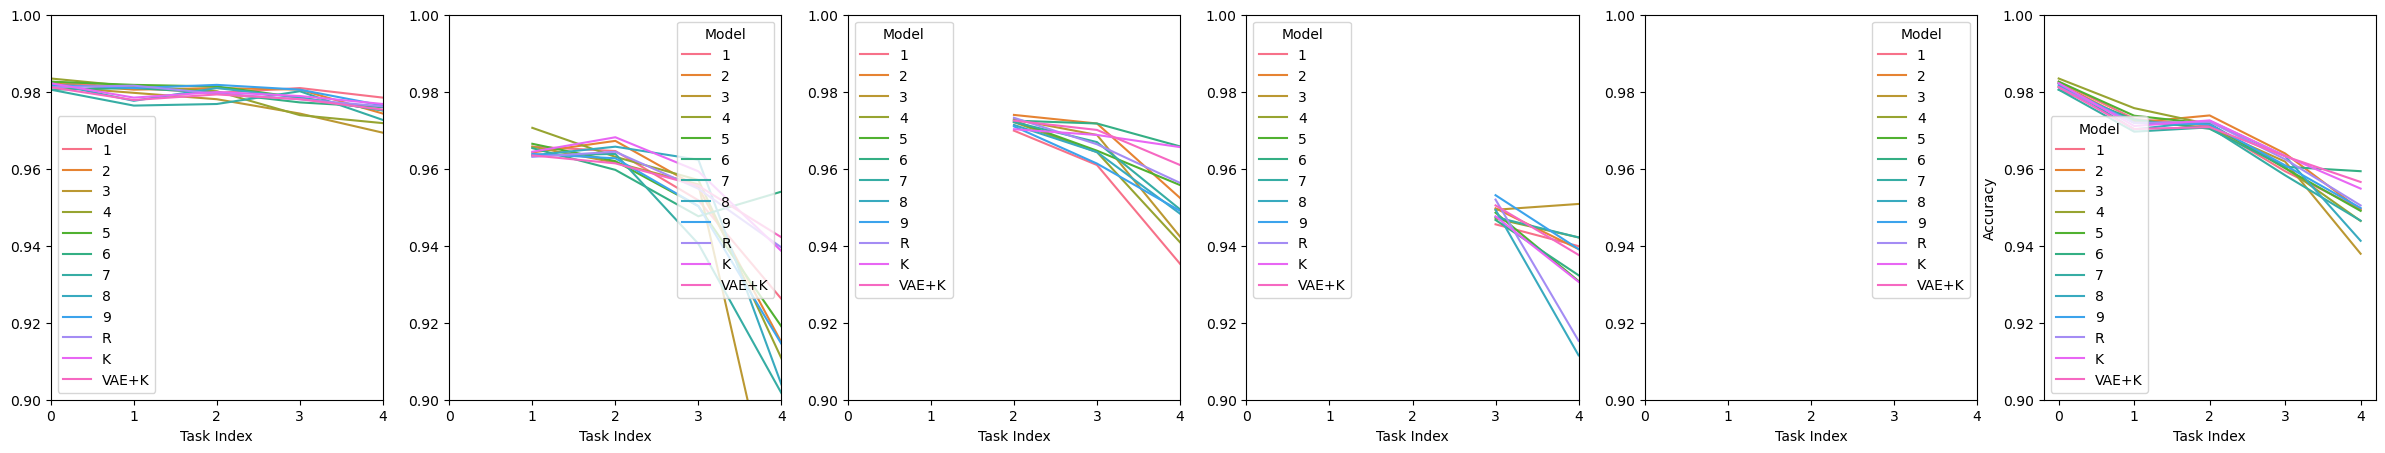

In [20]:
results_name = 'results/splitNotMNISTCoresetTestDifferentSizes2.pkl'

results_df = pd.read_pickle(results_name)
results_df2 = pd.read_pickle('results/splitNotMNISTCoresetTest3.pkl')

res =  pd.concat([results_df, results_df2], ignore_index=True, axis=0)
fig, axs = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
for i in range(5):
    p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=res[res['Target Task'] == i], ax=axs[i], errorbar=None)
    p.set(xlim=(0, 4))
    p.set(ylim=(0.9, 1))
    p.set_ylabel(None)
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=res[res['Target Task'] == 'All'], ax=axs[-1], errorbar=None)
p.set(ylim=(0.9, 1));


#### Normal coreset size (40)

In [5]:
results_df = new_results_df()

In [ ]:
base_config = {
    'dataset': 'split notMNIST',
    'first_init': Initialization.RANDOM,
    'subsequent_head_init': Initialization.RANDOM,
    'shared_net_init': None, 
    'batch_size': 100000, # (whole dataset)
}

var = [('R', 'random'), ('K', 'k-center'), ('VAE+K', 'vae-k-center')]
configs = [{'model_name': model_name, 'coreset_config': CoresetConfig(method=coreset_method), **dc(base_config)} for model_name, coreset_method in var]

results_name = 'results/splitNotMNISTCoresetTest1.pkl'
ensure_file_does_not_exist(results_name)

results_df = run_experiment(configs, results_df)
results_df = results_df.to_pickle(results_name)

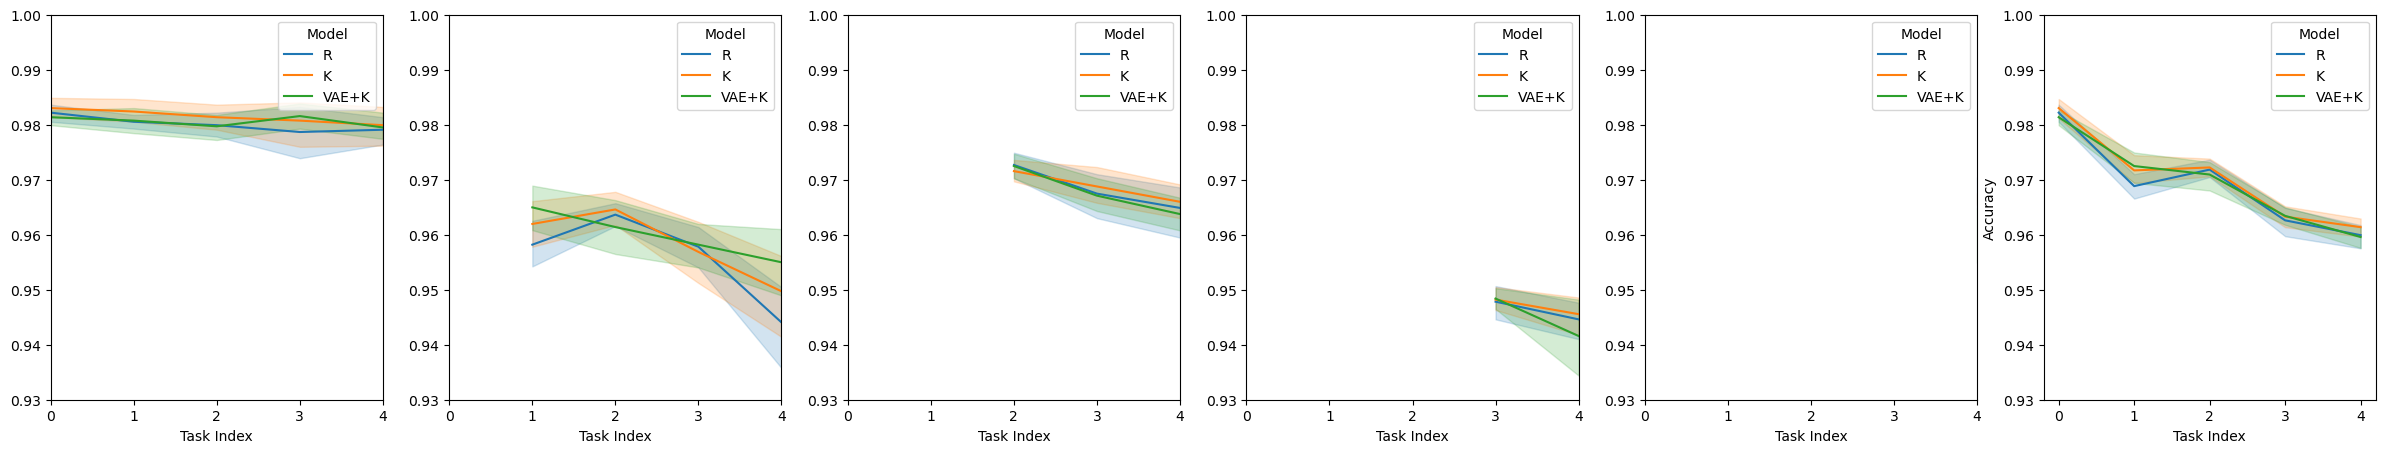

In [7]:
results_name = 'results/splitNotMNISTCoresetTest1.pkl'

results_df = pd.read_pickle(results_name)

fig, axs = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
for i in range(5):
    p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == i], ax=axs[i])
    p.set(xlim=(0, 4))
    p.set(ylim=(0.93, 1))
    p.set_ylabel(None)
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == 'All'], ax=axs[-1])
p.set(ylim=(0.93, 1));


#### Small coreset size (10)

In [8]:
results_df = new_results_df()

In [ ]:
base_config = {
    'dataset': 'split notMNIST',
    'first_init': Initialization.RANDOM,
    'subsequent_head_init': Initialization.RANDOM,
    'shared_net_init': None, 
    'batch_size': 100000, # (whole dataset)
}

var = [('R', 'random'), ('K', 'k-center'), ('VAE+K', 'vae-k-center')]
configs = [{'model_name': model_name, 'coreset_config': CoresetConfig(method=coreset_method, task_coreset_size=10), **dc(base_config)} for model_name, coreset_method in var]

results_name = 'results/splitNotMNISTCoresetTest2.pkl'
ensure_file_does_not_exist(results_name)

results_df = run_experiment(configs, results_df)
results_df = results_df.to_pickle(results_name)

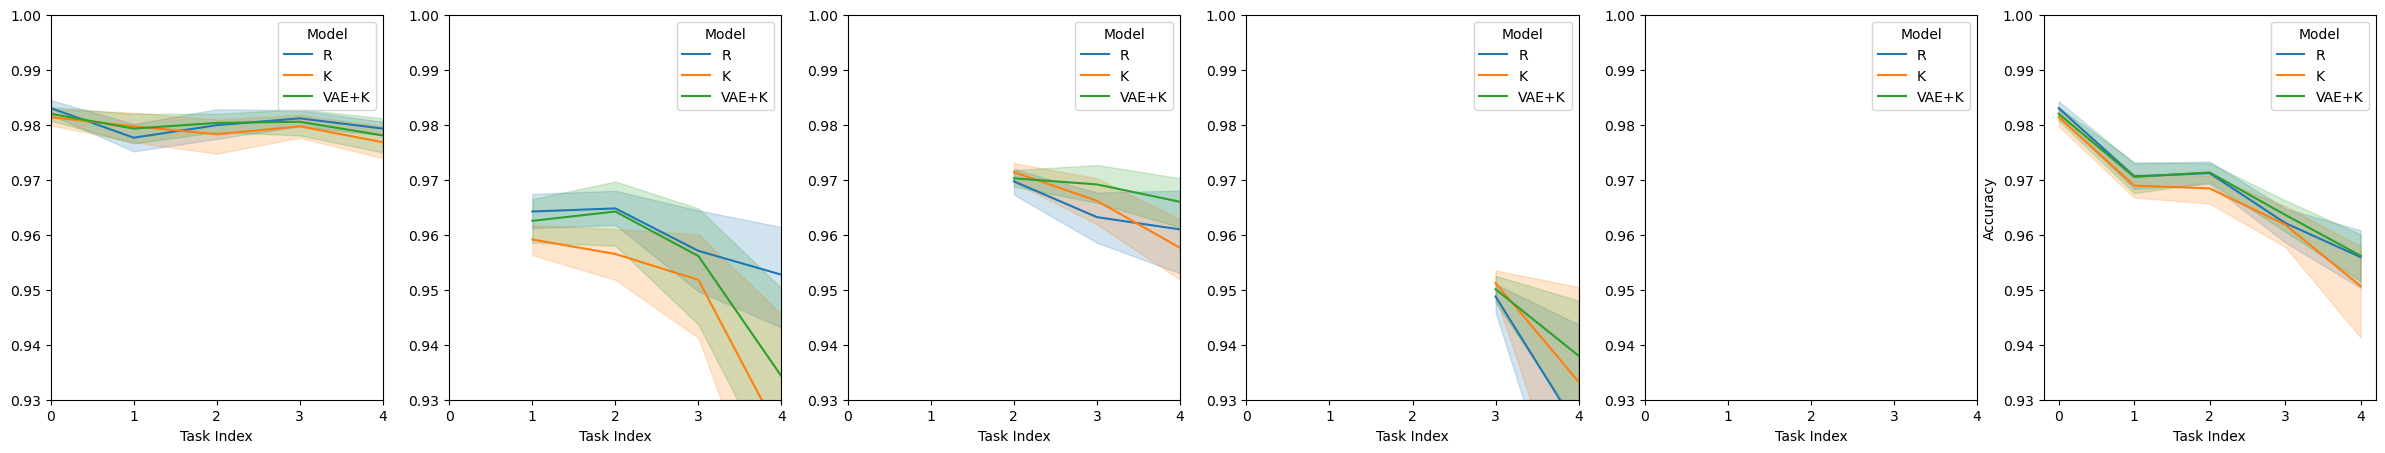

In [10]:
results_name = 'results/splitNotMNISTCoresetTest2.pkl'

results_df = pd.read_pickle(results_name)

fig, axs = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
for i in range(5):
    p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == i], ax=axs[i])
    p.set(xlim=(0, 4))
    p.set(ylim=(0.93, 1))
    p.set_ylabel(None)
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == 'All'], ax=axs[-1])
p.set(ylim=(0.93, 1));

#### Extra small coreset size (4)

In [11]:
results_df = new_results_df()

In [ ]:
base_config = {
    'dataset': 'split notMNIST',
    'first_init': Initialization.RANDOM,
    'subsequent_head_init': Initialization.RANDOM,
    'shared_net_init': None, 
    'batch_size': 100000, # (whole dataset)
}

var = [('R', 'random'), ('K', 'k-center'), ('VAE+K', 'vae-k-center')]
configs = [{'model_name': model_name, 'coreset_config': CoresetConfig(method=coreset_method, task_coreset_size=4), **dc(base_config)} for model_name, coreset_method in var]

results_name = 'results/splitNotMNISTCoresetTest3.pkl'
ensure_file_does_not_exist(results_name)

results_df = run_experiment(configs, results_df)
results_df = results_df.to_pickle(results_name)

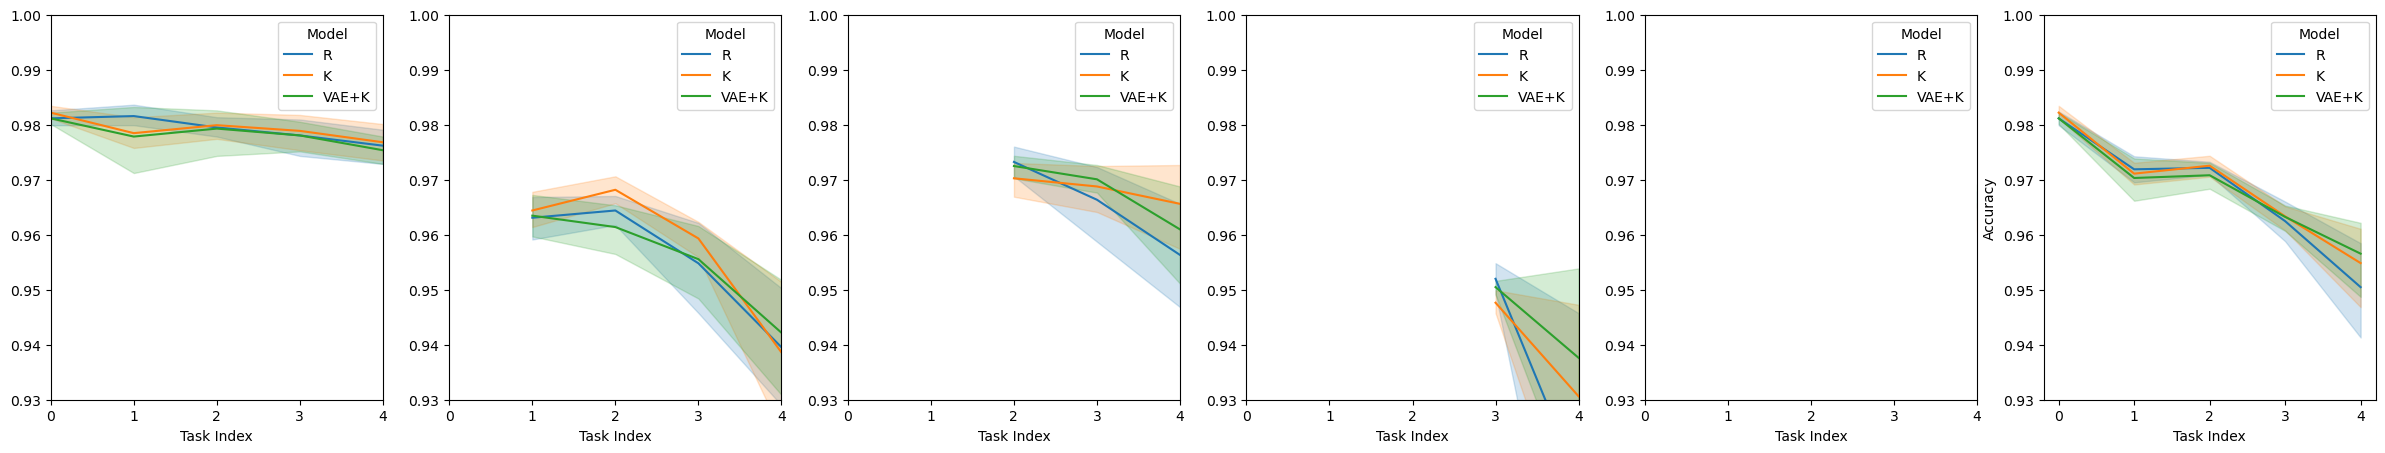

In [13]:
results_name = 'results/splitNotMNISTCoresetTest3.pkl'

results_df = pd.read_pickle(results_name)

fig, axs = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
for i in range(5):
    p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == i], ax=axs[i])
    p.set(xlim=(0, 4))
    p.set(ylim=(0.93, 1))
    p.set_ylabel(None)
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == 'All'], ax=axs[-1])
p.set(ylim=(0.93, 1));

#### Normal coreset size (40) (smaller batches) (ignore)

In [6]:
results_df = new_results_df()

In [7]:
base_config = {
    'dataset': 'split notMNIST',
    'first_init': Initialization.RANDOM,
    'subsequent_head_init': Initialization.RANDOM,
    'shared_net_init': None, 
    'batch_size': 256
}

var = [('R', 'random'), ('K', 'k-center'), ('VAE+K', 'vae-k-center')]
configs = [{'model_name': model_name, 'coreset_config': CoresetConfig(method=coreset_method, task_coreset_size=10), **dc(base_config)} for model_name, coreset_method in var]

results_name = 'results/splitNotMNISTCoresetTest4.pkl'
ensure_file_does_not_exist(results_name)

results_df = run_experiment(configs, results_df)
results_df = results_df.to_pickle(results_name)

Running experiment:   0%|          | 0/3 [00:00<?, ?it/s]

R:   0%|          | 0/10 [00:00<?, ?it/s]

K:   0%|          | 0/10 [00:00<?, ?it/s]

VAE+K:   0%|          | 0/10 [00:00<?, ?it/s]

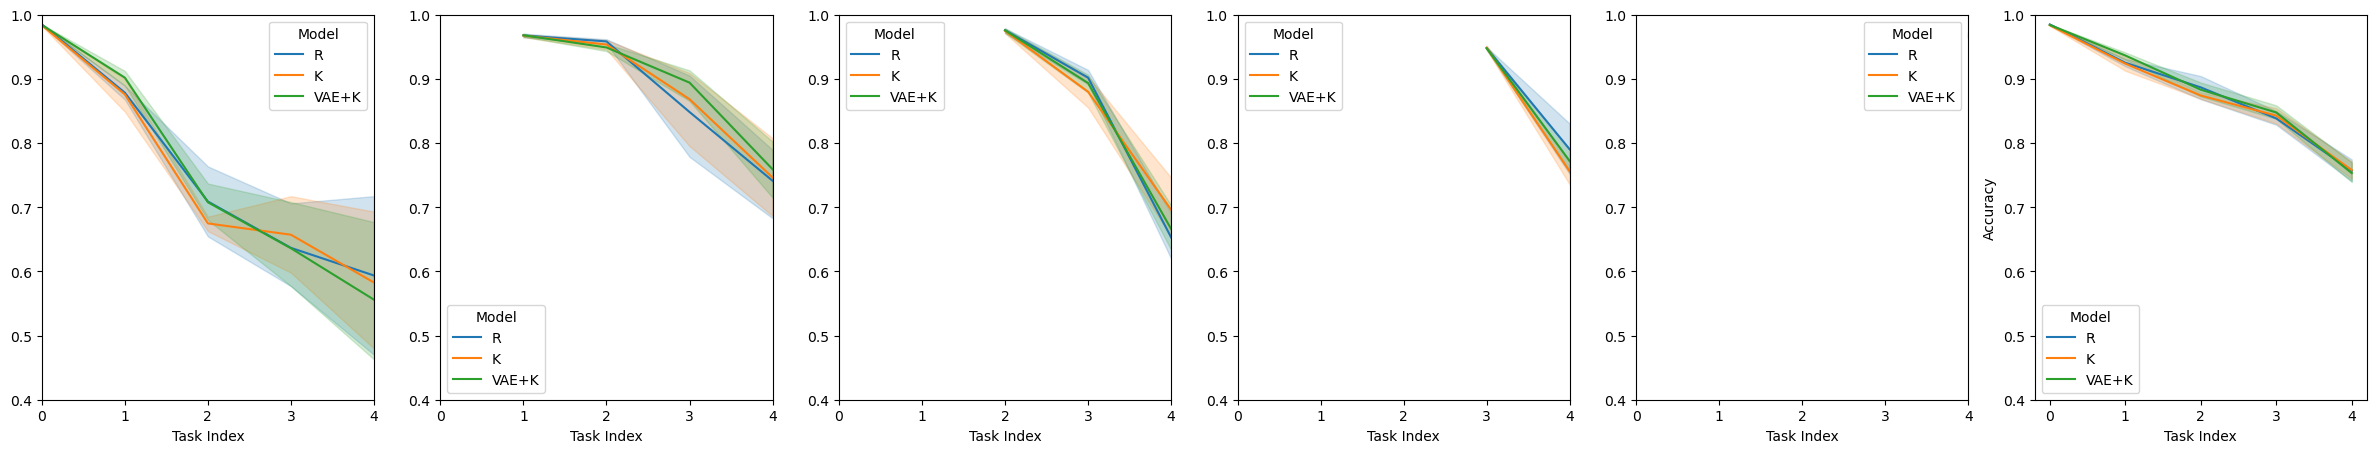

In [13]:
results_name = 'results/splitNotMNISTCoresetTest4.pkl'

results_df = pd.read_pickle(results_name)

fig, axs = plt.subplots(1, 6)
fig.set_size_inches(30, 5)
for i in range(5):
    p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == i], ax=axs[i])
    p.set(xlim=(0, 4))
    p.set(ylim=(0.40, 1))
    p.set_ylabel(None)
p = sns.lineplot(x="Task Index", y="Accuracy", hue="Model", data=results_df[results_df['Target Task'] == 'All'], ax=axs[-1])
p.set(ylim=(0.40, 1));